# load data

download dataset from kaggle [https://www.kaggle.com/xainano/handwrittenmathsymbols](https://www.kaggle.com/xainano/handwrittenmathsymbols) (a large `rar` file within `zip` file), and extract the images. The folder structure should be similar as below

```bash
Team-3-Quantum-Hackers-Project/
├── README.md
├── LICENSE
├── .gitignore
├── load_data.ipynb
└── extracted_images/
    ├── 0/
    |   ├── 0_100070.jpg
    |   ├── 0_100080.jpg
    |   ├── 0_100081.jpg
    |   └── ...
    ├── 1/
    ├── !/
    ├── (/
    ├── )/
    └── ...
```

In [104]:
import os
import time
import glob
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

import skimage
import sklearn.model_selection
import sklearn.svm

In [105]:
datadir = 'extracted_images'
all_label = os.listdir(datadir)
all_image_path = {x:[os.path.join(datadir,x,y) for y in os.listdir(os.path.join(datadir,x))] for x in all_label}
    
print('all label:', all_label)
print('some image path:')
for x in list(all_image_path.keys())[:4]:
    print(x, all_image_path[x][:2])

all label: ['div', 'e', '6', 'S', 'lt', ')', 'M', 'times', 'sigma', 'int', '3', 'N', 'prime', 'z', '}', '!', 'R', 'q', 'lambda', 'b', '(', 'f', '4', '7', 'leq', 'lim', 'l', 'sqrt', 'sin', '-', 'T', 'cos', '[', '5', 'p', 'tan', '+', 'rightarrow', '{', 'forall', 'geq', 'pm', 'alpha', 'ascii_124', 'mu', 'pi', 'j', 'G', 'in', 'theta', '1', 'ldots', 'i', '=', 'gt', 'forward_slash', 'w', 'phi', 'u', 'exists', 'gamma', 'X', 'Delta', ',', 'infty', 'A', 'sum', '2', 'log', 'y', '8', 'C', 'o', 'beta', 'v', 'H', 'k', '9', 'neq', '0', ']', 'd']
some image path:
div ['extracted_images/div/exp57073.jpg', 'extracted_images/div/exp17417.jpg']
e ['extracted_images/e/exp79934.jpg', 'extracted_images/e/exp70985.jpg']
6 ['extracted_images/6/exp54622.jpg', 'extracted_images/6/exp79934.jpg']
S ['extracted_images/S/s_46685.jpg', 'extracted_images/S/exp76781.jpg']


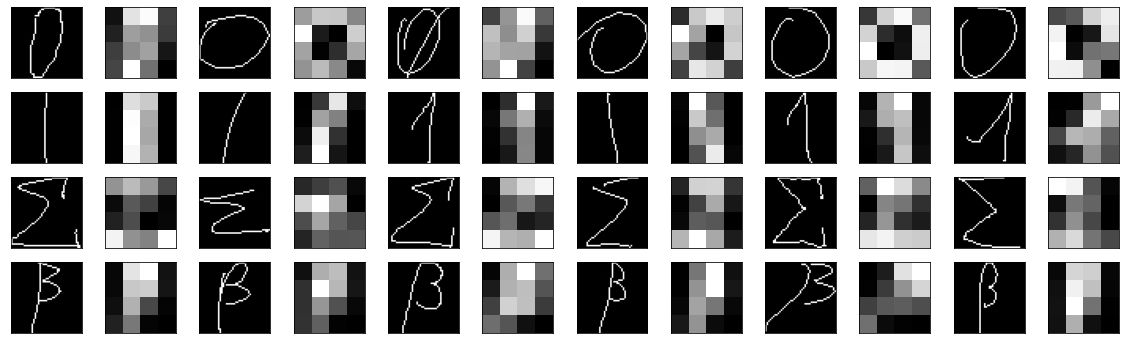

In [106]:
plot_label_list = ['0', '1', 'sum', 'beta']
num_column = 6
resize_image_size = 4, 4
# resize_image_size = 2,2
# resize_image_size = 4, 1
fig, ax_list = plt.subplots(nrows=len(plot_label_list), ncols=2*num_column, figsize=(20, 6))
for i in range(len(plot_label_list)):
    image_list = all_image_path[plot_label_list[i]]
    random_index = np.random.choice(np.arange(len(image_list)), size=num_column)
    for j in range(num_column):
        path = image_list[random_index[j]]
        image = np.array(PIL.Image.open(path))
        # image_small = np.array(PIL.Image.open(path).resize((resize_image_size[1],resize_image_size[0]))) #resize(width,height)
        image_small = skimage.transform.resize(image, resize_image_size, anti_aliasing=True)
        ax_list[i,2*j].imshow(image, cmap=plt.cm.gray_r)
        ax_list[i,2*j].set_xticks([])
        ax_list[i,2*j].set_yticks([])
        ax_list[i,2*j+1].imshow(image_small, cmap=plt.cm.gray_r)
        ax_list[i,2*j+1].set_xticks([])
        ax_list[i,2*j+1].set_yticks([])

**TODO**: how to combine it with Quantum Machine Learning

quantum SVM? CircuitQNN?

## preprocess data

1. select label
2. select part of the data, otherwise itt takes too long to train on the whole dataset
3. split train and test set

In [13]:
# binary classification
labels = ['0', '1']
label_to_int = {labels[0]:0, labels[1]:1}
class_size = 100
resize_image_size = 4, 4
# resize_image_size = 4, 1
seed = None #to fix the result, change it to seed=23 or some other integer

data_list = []
label_list = []
for x in labels:
    image_list = all_image_path[x]
    random_index = np.random.choice(np.arange(len(image_list)), size=class_size)
    for i in random_index:
        path = image_list[i]
        data_list.append(np.array(PIL.Image.open(path)))
        label_list.append(label_to_int[x])

data_list = [skimage.transform.resize(x, resize_image_size, anti_aliasing=True).reshape(-1) for x in data_list]
data_list = np.stack(data_list)
label_list = np.array(label_list)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
            data_list, label_list, test_size=0.2, shuffle=True, random_state=seed)

normalzie `x_train` to range `[min_,max_]` (a linear transformation), than apply the same transformation to `x_test`. It's possible that `x_test_normed` not in range `[min_,max_]`.

In [14]:
def normalize_data(x_train, x_test, min_, max_):
    # scale x_train to range [min_,max_]
    scale_a = (max_-min_)/(x_train.max()-x_train.min())
    scale_b = min_ - x_train.min()*scale_a
    x_train_normed = x_train*scale_a + scale_b

    # apply the same scale as x_test
    x_test_normed = x_test*scale_a + scale_b

    print('x_train_normed range from {:.3f} to {:.3f}'.format(x_train_normed.min(), x_train_normed.max()))
    print('x_test_normed range from {:.3f} to {:.3f}'.format(x_test_normed.min(), x_test_normed.max()))
    return x_train_normed, x_test_normed, scale_a, scale_b

x_train_normed,x_test_normed,_,_ = normalize_data(x_train, x_test, min_=0, max_=np.pi/2)

x_train_normed range from 0.000 to 1.571
x_test_normed range from 0.521 to 1.571


## quantum SVM

In [25]:
import concurrent.futures
import qiskit
import qiskit.providers.aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [16]:
aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=None)

# Image embedding as FRQI state

In [55]:
feature_dim = 4
print(feature_dim)

4


In [92]:
def frqi_state_4(feature_dimension):
    qc = QuantumCircuit(feature_dimension + 1)
    n_theta = 4*4
    theta = ParameterVector('theta', n_theta)

    for i in range(4):
        qc.h(i)

    # qc.barrier()

    for i in range(n_theta): 
        target_binary = "{0:04b}".format(i)
#         print('Target binary: ', target_binary)

        for index, value in list(enumerate(target_binary)):  
            if value == '1':
                qc.x(index)  

        qc.barrier()

        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 0)

        qc.cx(0, 1)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 1)

        qc.cx(0, 1)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 1)

        qc.cx(1, 2)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 2)

        qc.cx(0, 2)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 2)

        qc.cx(1, 2)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 2)

        qc.cx(0, 2)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 2)

        qc.cx(2, 3)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(2, 3)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(0, 3)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(2, 3)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(1, 3)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(0, 3)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(2, 3)
        qc.cry(-theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.cx(0, 3)
        qc.cry(theta[i]/4, target_qubit = 4, control_qubit = 3)

        qc.barrier()

        for index, value in list(enumerate(target_binary)):  
            if value == '1':
                qc.x(index)  

        qc.barrier()
            
    return qc

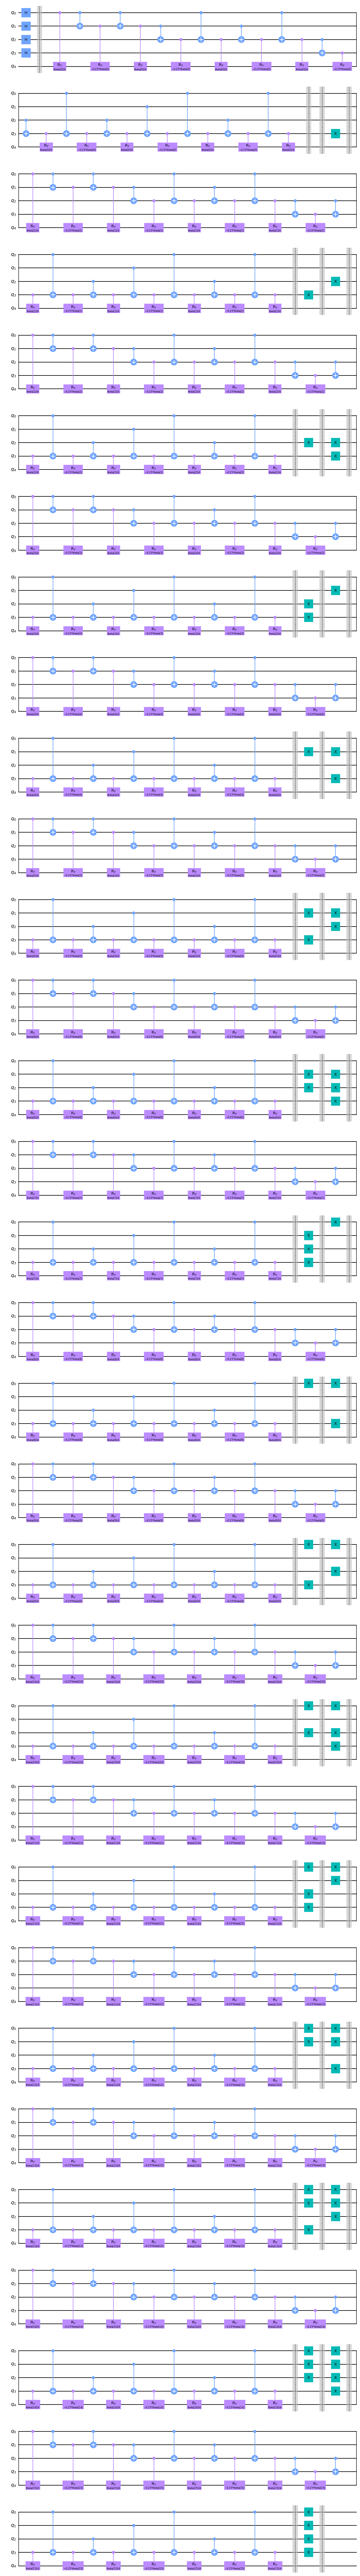

In [95]:
qc = frqi_state_4(feature_dim)
qc.draw('mpl')

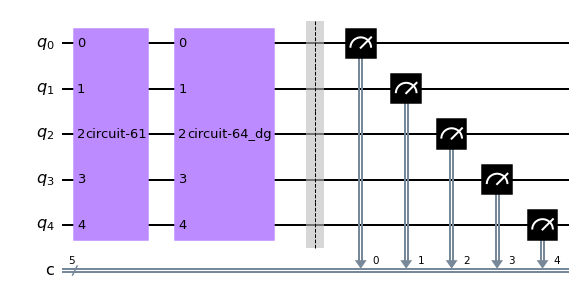

In [96]:
feature_map = frqi_state_4(feature_dim)
feature_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi_aer_qasm)

pauli_circuit = feature_kernel.construct_circuit(x_train_normed[0], x_train_normed[1])
pauli_circuit.draw('mpl')

## Classical SVC

In [107]:
model = sklearn.svm.SVC(kernel= feature_kernel.evaluate)

#Fiting the SVM model according to the given training data.
t0 = time.time()
model.fit(x_train_normed, y_train)
print('training time', time.time()-t0)

In [108]:
t0 = time.time()
accuracy = model.score(x_train_normed, y_train)
print('score(train) time', time.time()-t0)
print(f'classification accuracy on train set (size={len(y_train)}): {accuracy}')

t0 = time.time()
accuracy = model.score(x_test_normed, y_test)
print('score(test) time', time.time()-t0)
print(f'classification accuracy on test set (size={len(y_test)}): {accuracy}')
# not good, seems just random guess with accuracy 0.5

## On simulator

In [97]:
from qiskit import execute, Aer

# aer_qasm_sim = qiskit.providers.aer.QasmSimulator()
aer_qasm_sim = Aer.get_backend('aer_simulator')
qi_aer_qasm = qiskit.utils.QuantumInstance(aer_qasm_sim, shots=1024, seed_simulator=None)

In [98]:
job = execute(pauli_circuit, backend = aer_qasm_sim, shots = 1024)
counts = job.result().get_counts(pauli_circuit)
counts

{'01101': 1,
 '10001': 1,
 '10000': 1,
 '11110': 2,
 '10110': 6,
 '10011': 13,
 '11000': 3,
 '00000': 973,
 '10111': 14,
 '11011': 1,
 '10010': 9}

In [101]:
print(f"Transition amplitude: {counts['00000']/sum(counts.values())}")

Transition amplitude: 0.9501953125


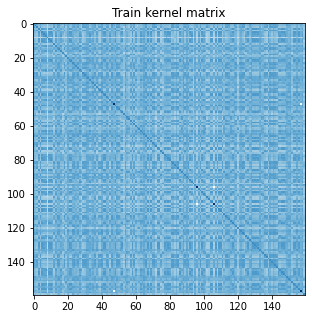

In [102]:
train_matrix= feature_kernel.evaluate(x_vec=x_train_normed)
test_matrix = feature_kernel.evaluate(x_vec=x_test, y_vec=x_train_normed)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

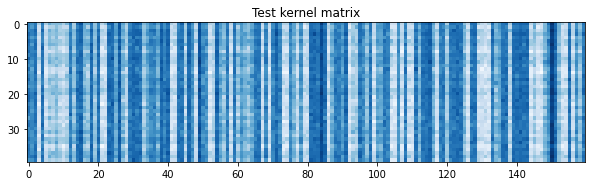

In [103]:
fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Test kernel matrix")
plt.show()